In [1]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_union, make_pipeline, Pipeline

from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import TimeSeriesSplit

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from fenginering.function import *
from fenginering.indicator import *
from fenginering.transformer import *
from data.get_data import *

%load_ext autoreload
%autoreload 2

In [2]:
start = "2022"
end = "2023"
data = get_data('GALA', '1h').loc[start : end]
data.drop(columns = ['symbol'], inplace = True)
data.columns = data.columns.astype(str)
data.shape

(10757, 5)

In [3]:
data['target'] = get_classification_target(data)
data = data.iloc[:-1]

## Add Indicators

In [4]:
from fenginering.preprocessing import Crossover

sma_list = [3, 7, 10, 14, 21, 30, 48, 72]
cross = Crossover(data)
data_c = cross.ma(sma, sma_list)
data_c.head()

,sma_3_sma_7,sma_3_sma_7dist,sma_3_sma_10,sma_3_sma_10dist,sma_3_sma_14,sma_3_sma_14dist,sma_3_sma_21,sma_3_sma_21dist,sma_3_sma_30,sma_3_sma_30dist,...,sma_21_sma_48dist,sma_21_sma_72,sma_21_sma_72dist,sma_30_sma_48,sma_30_sma_48dist,sma_30_sma_72,sma_30_sma_72dist,sma_48_sma_72,sma_48_sma_72dist,sma_48_sma_72_c
2022-01-03 23:00:00,1,2.005236,1,2.009517,1,2.015931,1,2.019076,1,2.024251,...,2.010901,1,2.014500,1,2.005793,1,2.009374,1,2.003560,2.026916
2022-01-04 00:00:00,1,2.007268,1,2.012223,1,2.019854,1,2.024914,1,2.030331,...,2.011878,1,2.015982,1,2.006559,1,2.010641,1,2.004056,2.058173
2022-01-04 01:00:00,1,2.011343,1,2.017406,1,2.025466,1,2.032812,1,2.038592,...,2.012932,1,2.017550,1,2.007295,1,2.011887,1,2.004559,2.058587
2022-01-04 02:00:00,1,2.015939,1,2.024248,1,2.032281,1,2.041067,1,2.047503,...,2.014196,1,2.019228,1,2.007964,1,2.012966,1,2.004962,2.055204
2022-01-04 03:00:00,1,2.011146,1,2.018040,1,2.025876,1,2.036307,1,2.043000,...,2.015015,1,2.020441,1,2.008502,1,2.013892,1,2.005345,2.045943


In [5]:
data_c.isna().sum().max()

0

In [6]:
lag_ret_list = [1, 3, 5, 9, 15, 30]
ema_list = [3, 9, 15]
rsi_list = [10, 14, 20]

atr_list = [10, 20, 25, 30, 48, 72]

macd_dict = {
    'slow' : [10, 14],
    'fast' : [3, 5],
    'signal' : [2, 3]
}

sar_dict = {
    'step' : [0.2],
    'max_step' : [0.2]
}

stochastic_oscillator_dict = {
    'k_period' : [10, 15, 20],
    'd_period' : [3, 5]
}

Indicators = MakeIndicator(data)
Indicators.set_stransformer(lag_returns, lag_ret_list)
#Indicators.set_stransformer(ema, ema_list)
Indicators.set_stransformer(rsi, rsi_list)
#Indicators.set_mtransformer(macd, macd_dict)
#Indicators.set_mtransformer(sar, sar_dict)
Indicators.set_mtransformer(stochastic_oscillator, stochastic_oscillator_dict)

Indicators.set_stransformer(atr, atr_list)

data_i = Indicators.df()

In [7]:
#data_i.drop(columns=['psar_0'], inplace = True)
#data_i.head()

# Normalisation

In [8]:
data = data_i.join(data_c)
data.dropna(inplace=True)

In [9]:
from fenginering.preprocessing import Normalisation

norm_scale = Normalisation(data)
data = norm_scale.transform()

<Axes: >

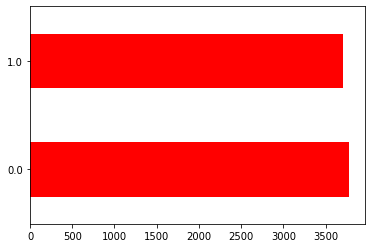

In [10]:
N = data.shape[0]
n = int(0.7*N)
train = data[:n]
test = data[n:]

features, target = train.drop(columns = ['target']), train['target']
features_test, target_test = test.drop(columns = ['target']), test['target']


target.value_counts().plot(kind = 'barh', color = 'red')

In [11]:
from sklearn.feature_selection import RFE, RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import TimeSeriesSplit

exp_cv = TimeSeriesSplit(n_splits = 10)
selector = RFECV(DecisionTreeClassifier(random_state = 0),
                 step = 3, cv = exp_cv,
                 min_features_to_select = 10
                 )
                 
selector.fit(features, target)

RFECV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
      estimator=DecisionTreeClassifier(random_state=0),
      min_features_to_select=10, step=3)

In [12]:
cols = features.columns[selector.support_]
cols

Index(['ret_1_0', 'ret_3_1', 'ret_15_4', 'rsi_0', 'stoch_k_signal_0',
       'stoch_k_signal_2', 'stoch_k_3', 'atr_5', 'sma_3_sma_7dist',
       'sma_10_sma_14dist', 'sma_21_sma_30dist', 'sma_48_sma_72dist', 'h_l'],
      dtype='object')

In [13]:
model = RandomForestClassifier()
model.fit(features[cols], target)

RandomForestClassifier()

 Accuracy : 0.53 
 f1 : 0.51 
 precision : 0.51 
 recall : 0.51 
 AUC : 0.54 
              precision    recall  f1-score   support

         0.0       0.55      0.55      0.55      1660
         1.0       0.51      0.51      0.51      1546

    accuracy                           0.53      3206
   macro avg       0.53      0.53      0.53      3206
weighted avg       0.53      0.53      0.53      3206



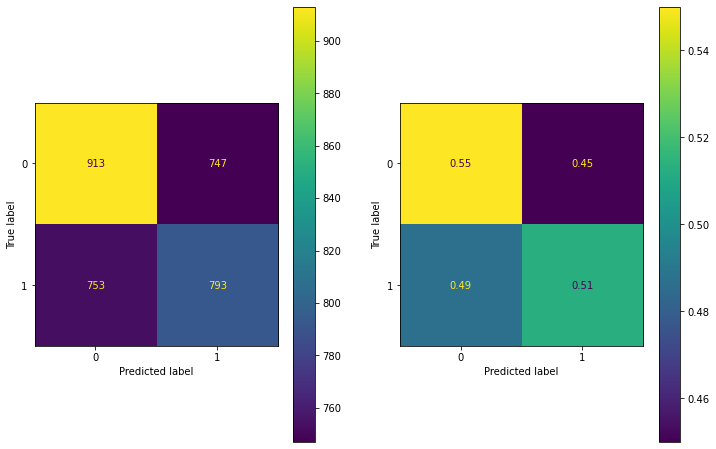

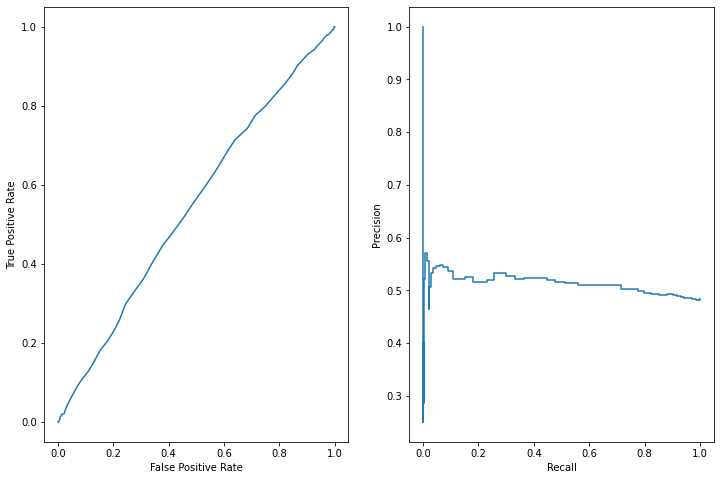

In [14]:
y_pred = model.predict(features_test[cols])
y_pred_proba = model.predict_proba(features_test[cols])

from evaluation.classification import *

evaluation = Evaluation(y_true = target_test, y_pred = y_pred, proba_pred = y_pred_proba[:,1])
evaluation.metrics()
evaluation.show()

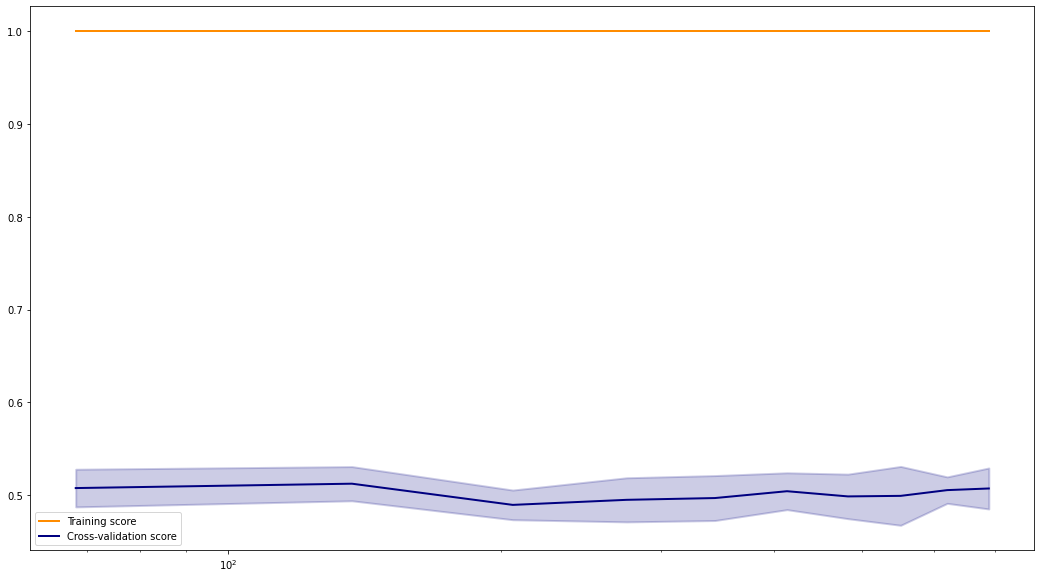

(array([ 68, 137, 206, 275, 344, 413, 482, 551, 620, 689]),
 array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]),
 array([[0.52135493, 0.48748159, 0.50073638, 0.51693667, 0.55522828,
         0.50515464, 0.49189985, 0.48159057, 0.51840943, 0.49926362],
        [0.53166421, 0.49337261, 0.51251841, 0.54197349, 0.53755523,
         0.49484536, 0.49631811, 0.49779087, 0.52282769, 0.49631811],
        [0.4742268 , 0.48011782, 0.49189985, 0.49631811, 0.5287187 ,
         0.49337261, 0.46980854, 0.47864507, 0.48453608, 0.49926362],
        [0.53460972, 

In [15]:
from evaluation.curve import learningCurve

learningCurve(model, features, target, exp_cv)

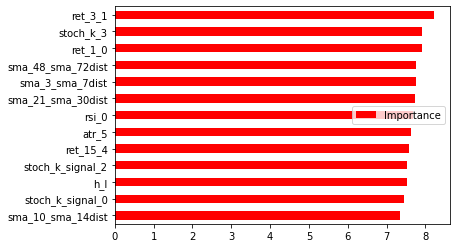

In [16]:
def feature_importances(model):
    Importance = pd.DataFrame({'Importance' : model.feature_importances_*100},
                          index = model.feature_names_in_)
    Importance.sort_values('Importance', axis = 0, ascending = True).plot(kind = 'barh', color = 'r')

feature_importances(model)

# With Calibration

# Backtesting

In [17]:
def backtest(features_test, target_test):
    backtest = pd.DataFrame()
    #backtest['returns'] = features_test.close.pct_change()
    backtest['returns'] = features_test.ret_1_0
    backtest['target'] = target_test
    backtest['pred'] = y_pred

    backtest['cum_ret'] = (1 + backtest['returns']).cumprod()

    backtest['strategy'] = backtest['returns']*backtest['pred']
    backtest['strategy_cum_ret'] = (1 + backtest['strategy']).cumprod()
    
    backtest[['cum_ret', 'strategy_cum_ret']].plot(figsize = (15, 10))
    

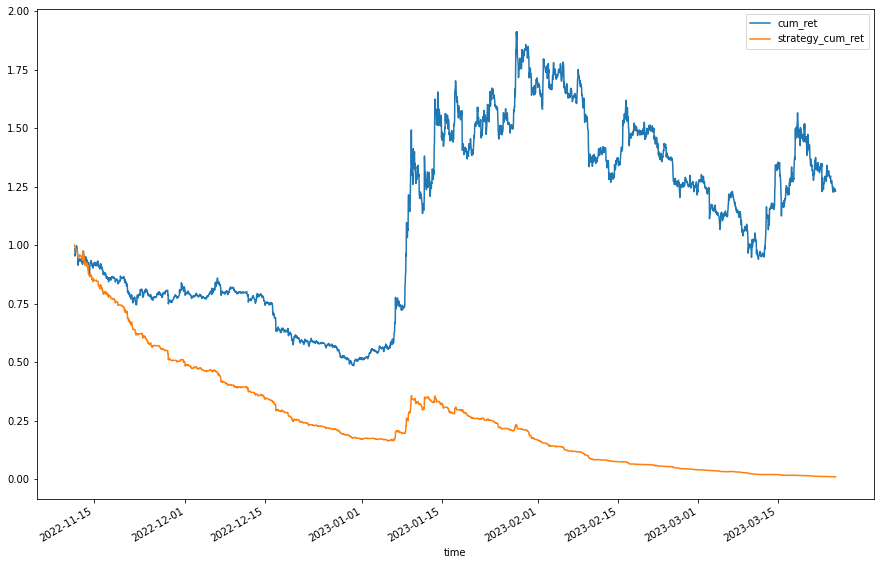

In [18]:
backtest(features_test, target_test)

## Fonction Cout

In [ ]:
def profit(y_true, y_pred, X):
    buy_price = X.close
    sell_price